# Модель для предсказания стоимости Б/У автомобиля.

Требуется построить модель для определения стоимости. Доступны следующие данные: технические характеристики, комплектации и цены автомобилей.

Критерии оптимальности модели:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

## Загрузка библиотек

In [8]:
# Загружаем лайтгбм через инсталлятор конды
conda install -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/peterefimov/opt/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.4                |   py37hc8dfbb8_2         3.0 MB  conda-forge
    lightgbm-2.3.0             |   py37h0a44026_0         594 KB
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.6 MB

The following NEW packages will be INSTALLED:

  lightgbm           pkgs/main/osx-64::lightgbm-2.3.0-py37h0a44026_0
  python_abi         conda-forge/osx-64::python_abi-3.7-1_cp

In [10]:
# Загружаем иксгбуст через инсталлятор конды
conda install -c anaconda py-xgboost

Solving environment: done

## Package Plan ##

  environment location: /Users/peterefimov/opt/anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  anaconda
    conda-4.8.4                |           py37_0         3.0 MB  anaconda
    libxgboost-0.90            |       h0a44026_1         2.4 MB  anaconda
    py-xgboost-0.90            |   py37h0a44026_1          77 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  anaconda/osx-64::_py-xgboost-mutex-2.0-cpu_0
  libxgboost         anaconda/osx-64::libxgboost-0.90-h0a44026_1
  py-xgboost         anaconda/osx-64::py-xgboost-0.90-py37h0a44026_1

The following packages will 

In [14]:
# Загружаем катбуст
pip install catboost

     |████████████████████████████████| 11.4 MB 4.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb
import xgboost  as xgb

from catboost import CatBoostRegressor, Pool, cv 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Предобработка данных

In [114]:
data = pd.read_csv('autos.csv')
# data = pd.read_csv('/datasets/autos.csv')

Посмотрим информацию о данных.

In [115]:
def data_information_printer(data):
    """Функция принимает на вход датасет и выводит основную информацию о нём"""
    display(data.head(10))
    print('Информация о признаках')
    display(data.info())
    print('Описание числовых признаков')
    display(data.describe())
    print('Информация о пропусках')
    display(data.isna().sum())
    print('Информация о дубликатах')
    display(data.duplicated().sum())

In [116]:
data_information_printer(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Информация о признаках
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dt

None

Описание числовых признаков


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Информация о пропусках


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Информация о дубликатах


4

Всего доступны данные о 354369 автомобилях. Данные либо целочисленные, либо категориальный в формате object. Смена типов не требуется. Также обнаружены 5 дубликатов.

Обнаружены пропуски в следующих признаках:
- Тип автомобиля
- Тип КПП
- Модель
- Тип топлива
- Был ли автомобиль в ремонте

Рассмотрим, какие ещё значения есть в признаках, кроме пропущенных:

In [117]:
lost_features = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Model']

for feature in lost_features:
    print(data[feature].value_counts())
    print()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

manual    268251
auto       66285
Name: Gearbox, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

no     247161
yes     36054
Name: NotRepaired, dtype: int64

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64



Рассмотрим информацию о ремонте: в большинстве случаев указано, что автомобиль не ремонтировался. Считаю, что в данном случае пропуск можно считать фактическим отсутствием ремонта автомобиля, так что можем заменить значение на 'no'.

В остальных случаях в каждом признаке есть значение other, которые фактически также является пропуском. Считаю наиболее грамотным и наименее затратным решением заменить пропущенные значение на other, таким образом мы сохраним данные и не изменим их начальное распределение.

In [118]:
data['NotRepaired'].fillna('no', inplace = True)

data['VehicleType'].fillna('other', inplace = True)
data['Gearbox'].fillna('other', inplace = True)
data['FuelType'].fillna('other', inplace = True)
data['Model'].fillna('other', inplace = True)

# Проверим результат
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Пропуски заменены, причём ни одна строка не потеряна. Теперь удалим дубликаты.

In [119]:
data.drop_duplicates(inplace = True)
display(data.duplicated().sum())

0

## Обработка признаков

В данном проекте одна из целей - получить быструю модель. Для этого требуется ограничить использование менее важных признаков с точки зрения обучения модели. Посмотрим, все ли признаки имеют разные значения:

In [120]:
data.nunique()

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   3
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
NotRepaired               2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Обнаружили, что признак количества фотографий принимает только одно значение, то есть бесполезен с точки зрения обучения. Такое же предположение можно сделать относительно признаков даты загрузки, скачивания объявления, почтовый индекс. Также считаю, что можно удалить признак месяца регистрации автомобиля. Считаю, что с точки зрения определения стоимости автомобиля в зависимости от его возраста год - более показательный период, чем месяц.

Удалим избыточные признаки:

In [121]:
data = data.drop(['DateCrawled','RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'],
                 axis = 1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Ранее было выявлено, что есть нулевые значения цены и мощности автомобиля, а также могут быть выбросы в годе выпуска автомобиля. Посмотрим на их распределения.

In [122]:
def distribution_visualization(data, features):
    """Рисует гистограммы и боксплоты для признаков. На вход подаётся датасет и лист признаков"""
    for feature in features_distribution:
        data.boxplot(column = feature, vert=False, figsize=(10,2))
        plt.show()
        data[feature].hist(figsize=(10,6), bins = 50)  
        plt.show()

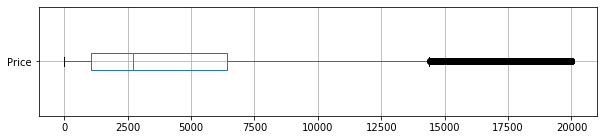

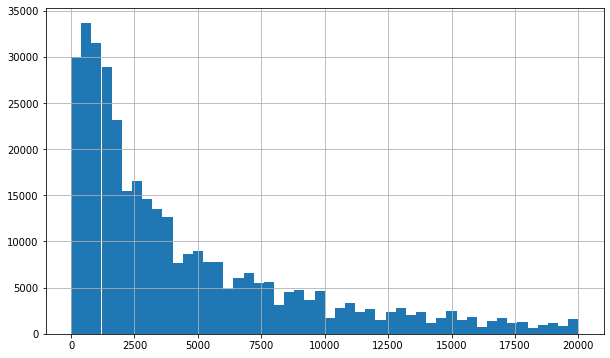

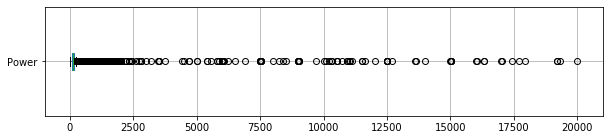

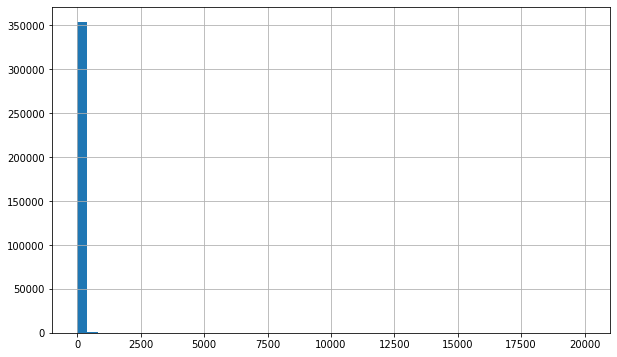

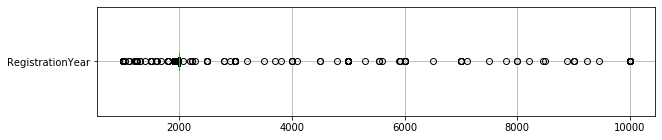

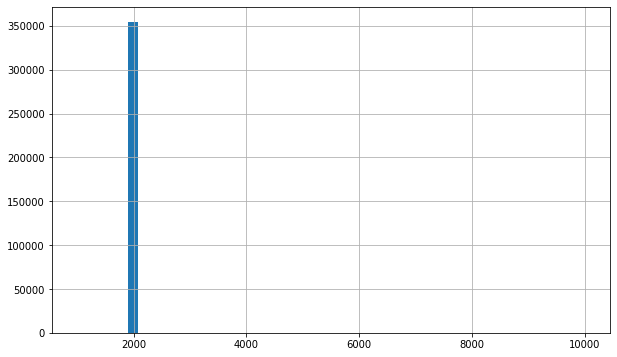

In [123]:
features_distribution = ['Price', 'Power', 'RegistrationYear']

distribution_visualization(data, features_distribution)

Наблюдаем явные выбросы. Зададим ограничения и удалим выбросы:
1. Цена не должна быть нулевой
2. Мощность не должна быть нулевой
3. Год регистрации установим в диапазоне от 1900 до 2017 (случаи автомобилей старше 1900 эксклюзивны, а дата регистрации позже выгрузки объявлений невозможна).
4. Ограничим мощность 1000 л.с., как адекватной для гражданских автомобилей. Мощность выше соответствуем эксклюзивным случаям, которые вряд ли следует рассматривать в рамках обучения массовых моделей. К тому же скорее всего такая мощность указана ошибочно.

In [124]:
data_processed = data.query('Price != 0 and 0 < Power < 1000 and 1900 < RegistrationYear < 2017')

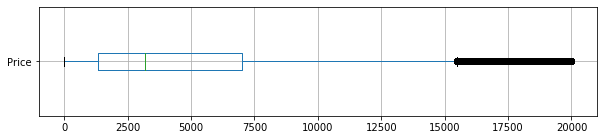

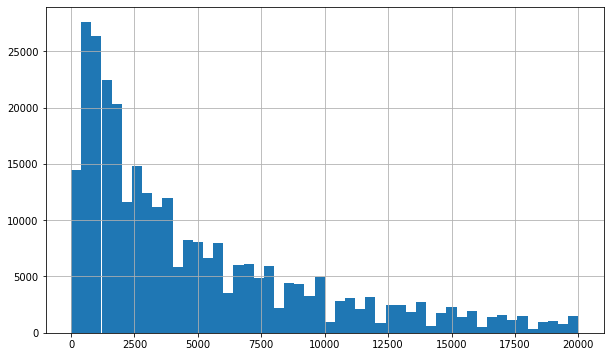

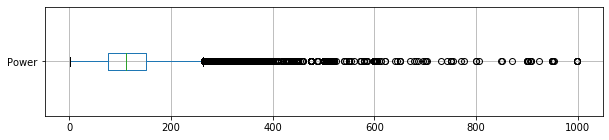

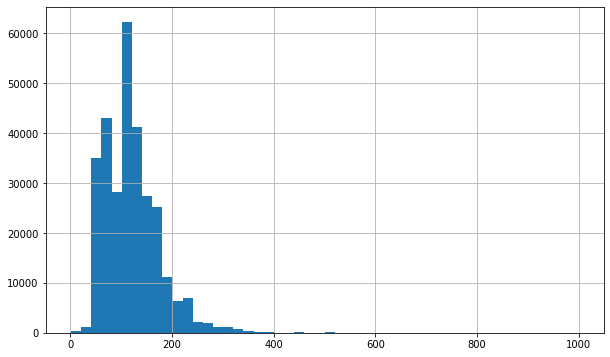

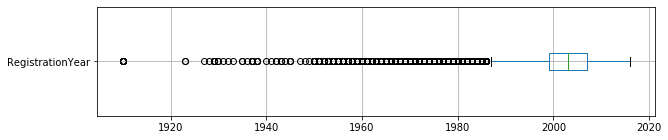

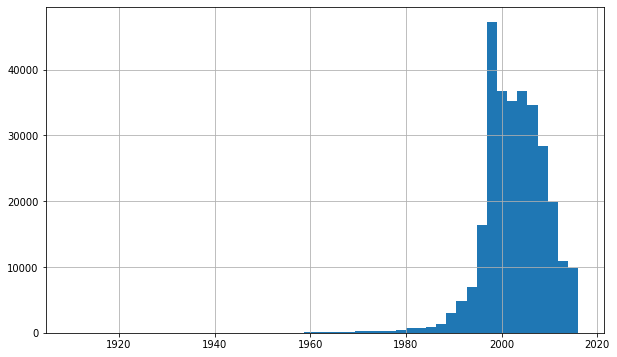

In [125]:
# Оценим распределения ещё раз

distribution_visualization(data_processed, features_distribution)

Теперь получили более адекватные распределения.

In [68]:
# Оценим потерю данных
print((len(data) - len(data_processed)) / len(data))

0.1629285141831563


Явные выбросы в данных удалены, потеряно около 17% данных. Считаю это обоснованным, а оставшихся данных достаточно для изучения моделей.

# 2. Обучение моделей

В данном пункте изучим 3 алгоритма моделей - LightGBM, Catboost, XGBoost, обучив их на кросс-валидации. Таким образом, мы качественно оценим скорость работы моделей и их ошибку RMSE. Далее отберём наиболее подходящие гиперпараметры для каждого алгоритма и пересчитаем RMSE, а также оценим время их обучения и предсказания - сделаем вывод о наиболее подходящей модели.

## Подготовка данных к обучению

Сперва разделим данные на определяющие признаки и целевой признак:

In [145]:
features = data_processed.drop(['Price'], axis = 1)
target = data_processed['Price']

features.shape, target.shape

((296628, 9), (296628,))

Теперь напишем функцию для определения категориальных признаков:

In [146]:
def categorial_features_finder(data):
    """Функция принимает на вход датафрейм и возвращает список названий столбцов с типом object"""
    cat_col_list = []
    for column in data.columns:
        if data[column].dtype == 'object':
            cat_col_list.append(column)
    return cat_col_list

In [147]:
categorial_features = categorial_features_finder(features)
categorial_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

## Модель LightGBM

Изучим модель LightGBM

In [174]:
# Скопируем датасет features отдельно для LGBM
features_lgb = features.copy()

In [162]:
# Напишем функцию для обучения модели

def LightGBM(parameters, features, target, cv):
    """Функция обучает модель по алгоритму lightgbm, на вход принимает словарь параметров,
    датафрейм features и target и количество folds для кросс-валидации.
    Возвращает значение RMSE на кросс-валидации"""
    
    # Присваиваем категориальным признакам тип 'category'
    categorial_columns = categorial_features_finder(features)
    for column in categorial_columns:
        features[column] = features[column].astype('category')
    
    # Делим датасет на обучающие и тестовые выборки
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 13)
    
    # Готовим датасет в формате LightGBM
    d_train = lgb.Dataset(X_train, label = y_train)
    
    # Обучаем модель
    cv_rmse = lgb.cv(parameters, d_train, nfold = cv, early_stopping_rounds = 1, show_stdv = False)
    
    return cv_rmse

In [168]:
# Создадим первый словарь параметров для модели лгбм
parameters_lgbm_1 = {
    'application': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 30,
    'max_depth': 5,
    'feature_fraction': 0.5,
    'learning_rate': 0.25,
    'metric': 'rmse',
    'random_state': 13
}

In [169]:
%%time

LightGBM(parameters_lgbm_1, features_lgb, target, 4)

/Users/peterefimov/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 10.5 s, sys: 138 ms, total: 10.6 s
Wall time: 3.19 s


{'rmse-mean': [4127.457106142372,
  3482.1271891657807,
  2979.39441684544,
  2833.9714913309117,
  2549.822675987597,
  2321.053212707665,
  2177.9026812225907,
  2078.7694337908943,
  2037.1917382811635,
  1982.3335089437842,
  1937.1240532835702,
  1923.0322053133148,
  1905.385685671311,
  1883.4804547939257,
  1864.760308620711,
  1838.6794980909165,
  1830.5480353395067,
  1803.4556725205255,
  1800.2703196815003,
  1782.215163448512,
  1772.6119946670854,
  1762.192005259131,
  1757.3170556353748,
  1749.8577464330515,
  1739.1762171161586,
  1735.877834534109,
  1732.228115912054,
  1729.5233098588892,
  1722.9054991781602,
  1717.2498223294153,
  1712.83047876456,
  1711.163721355152,
  1708.4084483586998,
  1706.8457865746036,
  1701.710122182269,
  1698.5047816865092,
  1696.7207828486,
  1695.0026290343199,
  1693.9434346561843,
  1692.9182625888366,
  1689.3318784252267,
  1686.4733719054539,
  1685.6387954783304,
  1683.1377399789249,
  1681.0303965824642,
  1679.37095046

In [170]:
# Создадим второй вариант словарь параметров для модели лгбм
parameters_lgbm_2 = {
    'application': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 60,
    'max_depth': 10,
    'feature_fraction': 0.8,
    'learning_rate': 0.5,
    'metric': 'rmse',
    'random_state': 13
}

In [171]:
%%time

LightGBM(parameters_lgbm_2, features, target, 4)

/Users/peterefimov/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 9.77 s, sys: 160 ms, total: 9.92 s
Wall time: 3.09 s


{'rmse-mean': [2975.389383934439,
  2281.3420108353353,
  1995.2438180210575,
  1874.0018055004425,
  1793.7155461159532,
  1761.8893350705853,
  1739.1022838554582,
  1726.3322678683464,
  1718.0959050546721,
  1707.1167454812455,
  1701.7638119966603,
  1696.476310187732,
  1688.652003393066,
  1681.9943500336292,
  1677.5262860499124,
  1672.490757481787,
  1670.1394267087567,
  1666.4297809228335,
  1662.7415814110234,
  1660.2895526663328,
  1658.0889248676253,
  1655.6620080431371,
  1654.0122942260236,
  1651.351958508841,
  1649.7279018115032,
  1647.6828122848947,
  1646.2590152378643,
  1645.3005854074167,
  1643.376092122706,
  1641.2353928822904,
  1638.7513567370315,
  1637.3528987388504,
  1635.9783787232227,
  1635.209852844795,
  1634.148774088794,
  1632.9162645864885,
  1632.3114433256144,
  1631.5403101595039,
  1630.2326718643174,
  1629.249145682801,
  1628.1406955737734,
  1626.452005244138,
  1625.667404226735,
  1624.3847989040953,
  1624.0736387764505,
  1623.5

In [172]:
# Создадим третий вариант словарь параметров для модели лгбм
parameters_lgbm_3 = {
    'application': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 100,
    'max_depth': 15,
    'feature_fraction': 1.0,
    'learning_rate': 0.75,
    'metric': 'rmse',
    'random_state': 13
}

In [173]:
%%time

LightGBM(parameters_lgbm_3, features, target, 4)

/Users/peterefimov/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 6.79 s, sys: 99.4 ms, total: 6.89 s
Wall time: 2.16 s


{'rmse-mean': [2316.125828129532,
  1899.8043288360564,
  1812.7048388754718,
  1773.255574481735,
  1747.9368535103376,
  1729.5054581761437,
  1717.3444937050167,
  1708.4449370652037,
  1704.0551455288344,
  1697.3699929928605,
  1692.8076866130286,
  1688.075454215552,
  1682.638511240102,
  1679.5448328296934,
  1674.8951042046865,
  1672.3838372384712,
  1669.6775113653675,
  1669.0104600785792,
  1666.8084369106286,
  1663.7377645895453,
  1662.0071334675768,
  1660.982628249192,
  1659.9300093834086,
  1658.9984434783614,
  1658.2341351222879,
  1657.4612930259343,
  1656.2820020263,
  1655.3777108349886,
  1654.859892246685],
 'rmse-stdv': [8.868191052331767,
  11.870220165433098,
  12.769046983950854,
  13.267181726244493,
  14.782792887967139,
  13.856851461641146,
  11.2065294403879,
  12.489334630278147,
  10.560448991141246,
  9.617425368344009,
  9.330230023321718,
  12.341956646680039,
  12.047007012630992,
  11.63617380947177,
  11.826361313879179,
  10.226524562881144

Считаю наиболее оптимальной по скорости и точности модель на втором наборе параметров. Сохраним их в отдельную переменную.

In [183]:
LGBM_best_params = parameters_lgbm_2
display(LGBM_best_params)

{'application': 'regression',
 'boosting': 'gbdt',
 'num_leaves': 60,
 'max_depth': 10,
 'feature_fraction': 0.8,
 'learning_rate': 0.5,
 'metric': 'rmse',
 'random_state': 13}

## Модель Catboost

In [211]:
features_cat = features.copy()

In [155]:
# Напишем функцию для обучения модели

def CatBoost(parameters, features, target):
    """Функция обучает модель по алгоритму catboost, на вход принимает словарь параметров,
    датафрейм features и target.
    Возвращает значение RMSE на кросс-валидации"""
    
    # Делим датасет на обучающие и тестовые выборки
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 13)
    
    categorial_features = categorial_features_finder(features)
    
    # Готовим датасет для кэтбуста
    train_pool = Pool(X_train, label = y_train, cat_features = categorial_features)
    
    cv_score = cv(train_pool, parameters, fold_count = 4, verbose = 5)

In [156]:
# Создадим первый вариант словаря параметров для кэтбуста

parameters_catboost_1 = {
    'n_estimators': 50,
    'max_depth': 5,
    'learning_rate': 0.25,
    'loss_function': 'RMSE',
    'random_seed': 13,
}

In [157]:
%%time

CatBoost(parameters_catboost_1, features_cat, target)

0:	learn: 5352.2578877	test: 5352.9460905	best: 5352.9460905 (0)	total: 312ms	remaining: 15.3s
5:	learn: 2626.6550775	test: 2627.2547256	best: 2627.2547256 (5)	total: 1.22s	remaining: 8.98s
10:	learn: 2123.5498445	test: 2124.8835596	best: 2124.8835596 (10)	total: 2.04s	remaining: 7.24s
15:	learn: 1983.4299212	test: 1986.6210933	best: 1986.6210933 (15)	total: 2.85s	remaining: 6.06s
20:	learn: 1927.0602613	test: 1931.3910456	best: 1931.3910456 (20)	total: 3.64s	remaining: 5.03s
25:	learn: 1891.0516037	test: 1896.5998402	best: 1896.5998402 (25)	total: 4.52s	remaining: 4.17s
30:	learn: 1867.5138264	test: 1874.6304171	best: 1874.6304171 (30)	total: 5.4s	remaining: 3.31s
35:	learn: 1847.8309461	test: 1855.6723979	best: 1855.6723979 (35)	total: 6.27s	remaining: 2.44s
40:	learn: 1831.1167433	test: 1839.0869743	best: 1839.0869743 (40)	total: 7.09s	remaining: 1.56s
45:	learn: 1814.8106545	test: 1823.8103954	best: 1823.8103954 (45)	total: 7.92s	remaining: 688ms
49:	learn: 1805.0240462	test: 1814.

In [153]:
# Создадим второй вариант словаря параметров для кэтбуста

parameters_catboost_2 = {
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.5,
    'loss_function': 'RMSE',
    'random_seed': 13,
}

In [158]:
%%time

CatBoost(parameters_catboost_2, features_cat, target)

0:	learn: 4015.1265613	test: 4016.4888889	best: 4016.4888889 (0)	total: 546ms	remaining: 54.1s
5:	learn: 1875.3900254	test: 1886.4165799	best: 1886.4165799 (5)	total: 1.99s	remaining: 31.2s
10:	learn: 1756.4445167	test: 1782.1846254	best: 1782.1846254 (10)	total: 3.35s	remaining: 27.1s
15:	learn: 1703.0571000	test: 1739.1817453	best: 1739.1817453 (15)	total: 5.13s	remaining: 26.9s
20:	learn: 1660.1622394	test: 1708.7965343	best: 1708.7965343 (20)	total: 7.04s	remaining: 26.5s
25:	learn: 1631.3586955	test: 1690.6836242	best: 1690.6836242 (25)	total: 8.58s	remaining: 24.4s
30:	learn: 1608.3035129	test: 1677.6303340	best: 1677.6303340 (30)	total: 10.1s	remaining: 22.5s
35:	learn: 1587.1553684	test: 1666.3334046	best: 1666.3334046 (35)	total: 11.7s	remaining: 20.8s
40:	learn: 1569.6059470	test: 1658.4345141	best: 1658.4345141 (40)	total: 13.1s	remaining: 18.9s
45:	learn: 1553.5771595	test: 1650.9847672	best: 1650.9847672 (45)	total: 14.6s	remaining: 17.2s
50:	learn: 1539.0898550	test: 1644

In [164]:
# Создадим третий вариант словаря параметров для кэтбуста

parameters_catboost_3 = {
    'n_estimators': 75,
    'max_depth': 8,
    'learning_rate': 0.7,
    'loss_function': 'RMSE',
    'random_seed': 13,
}

In [165]:
%%time

CatBoost(parameters_catboost_3, features_cat, target)

0:	learn: 3200.0617834	test: 3201.7762084	best: 3201.7762084 (0)	total: 439ms	remaining: 32.5s
5:	learn: 1913.5057733	test: 1923.7171845	best: 1923.7171845 (5)	total: 1.55s	remaining: 17.9s
10:	learn: 1802.6114503	test: 1823.6129391	best: 1823.6129391 (10)	total: 2.73s	remaining: 15.9s
15:	learn: 1753.8201764	test: 1781.5308128	best: 1781.5308128 (15)	total: 3.86s	remaining: 14.2s
20:	learn: 1719.4290042	test: 1754.9690479	best: 1754.9690479 (20)	total: 4.9s	remaining: 12.6s
25:	learn: 1690.2042413	test: 1733.9445605	best: 1733.9445605 (25)	total: 6.03s	remaining: 11.4s
30:	learn: 1665.9185857	test: 1718.7588769	best: 1718.7588769 (30)	total: 7.23s	remaining: 10.3s
35:	learn: 1644.5716478	test: 1703.3976079	best: 1703.3976079 (35)	total: 8.56s	remaining: 9.28s
40:	learn: 1627.8980980	test: 1693.1023481	best: 1693.1023481 (40)	total: 9.7s	remaining: 8.05s
45:	learn: 1613.9644048	test: 1686.3860097	best: 1686.3860097 (45)	total: 10.8s	remaining: 6.82s
50:	learn: 1601.5365023	test: 1680.4

Модель Catboost работает медленее LGBM, однако показывает лучшее значение RMSE. Сравнима по точности и скорости она при использовании третьего набора гиперпараметров. Сохраним их.

In [184]:
Catboost_best_params = parameters_catboost_3
display(Catboost_best_params)

{'n_estimators': 75,
 'max_depth': 8,
 'learning_rate': 0.7,
 'loss_function': 'RMSE',
 'random_seed': 13}

## Модель XGBooster

In [175]:
features_xgb = features.copy()

Напишем функцию для кросс-валидации XGBooster

In [179]:
def XGBoosterRegressor(parameters, features, target):
    """Функцияя принимает на вход параметры, features и target
    Делает кодирование категориальных признаков для их адаптации к модели XGB
    возвращает скор для модели XGB"""
    features_new = pd.get_dummies(features, drop_first = True)
    
    # Делим датасет на обучающие и тестовые выборки
    X_train, X_test, y_train, y_test = train_test_split(features_new, target, test_size = 0.2, random_state = 13)

    d_train = xgb.DMatrix(X_train, label = y_train)
    
    cv_score = xgb.cv(parameters, d_train, nfold = 4)
    
    return cv_score

In [177]:
parameters_XGBooster_1 = {
    'objective': 'reg:linear',
    'n_estimators': 50,
    'max_depth': 5,
    'eta': 0.25,
    'eval_metric': 'rmse',
    'seed': 13
}

In [180]:
%%time

XGBoosterRegressor(parameters_XGBooster_1, features_xgb, target)

[15:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 58s, sys: 12.8 s, total: 4min 11s
Wall time: 1min 17s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5269.871948,6.249725,5270.775635,24.617780
1,4251.702027,3.725088,4252.550537,23.840003
2,3522.542481,2.867662,3524.813781,20.610652
3,3015.238281,3.519012,3018.852478,17.198582
4,2671.291504,2.518125,2676.119385,16.229703
5,2436.235230,3.693790,2441.587097,14.020220
6,2279.513672,2.702017,2285.903137,13.282044
7,2167.535278,4.973609,2174.538636,12.014410
8,2086.064026,6.886576,2094.907776,13.202143
9,2028.103149,7.548124,2038.657898,12.880889


In [186]:
# Попробуем получить мЕньшую ошибку на новом наборе гиперпараметров

parameters_XGBooster_2 = {
    'objective': 'reg:linear',
    'n_estimators': 75,
    'max_depth': 7,
    'eta': 0.25,
    'eval_metric': 'rmse',
    'seed': 13
}

In [187]:
%%time

XGBoosterRegressor(parameters_XGBooster_2, features_xgb, target)

[10:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 50s, sys: 10.4 s, total: 5min 1s
Wall time: 1min 29s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5221.269531,6.073413,5223.083496,23.917078
1,4159.621948,3.991392,4163.398071,22.279162
2,3404.288208,3.537789,3410.744995,20.261047
3,2875.730957,3.364748,2886.062561,17.915143
4,2510.736450,3.411873,2524.861389,15.993042
5,2262.769470,3.410021,2280.731812,13.088094
6,2096.346130,2.279791,2118.372253,10.185581
7,1982.109955,2.702962,2007.801361,11.914775
8,1903.821442,2.628291,1933.145477,11.107847
9,1846.639374,4.041208,1879.544159,10.951440


Попробуем убрать признак мощности, как наиболее насыщенный уникальными значениями, из features и оценить, как это повлияет на скорость и точность модели.

In [192]:
features_xgb_new = features_xgb.drop(['Power'], axis = 1)
features_xgb_new.head()

,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,other,125000,gasoline,audi,yes
2,suv,2004,auto,grand,125000,gasoline,jeep,no
3,small,2001,manual,golf,150000,petrol,volkswagen,no
4,small,2008,manual,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,3er,150000,petrol,bmw,yes


In [193]:
# Зададим ещё один словарь параметров для модели:

parameters_XGBooster_3 = {
    'objective': 'reg:linear',
    'n_estimators': 100,
    'max_depth': 10,
    'eta': 0.25,
    'eval_metric': 'rmse',
    'seed': 13
}

In [194]:
%%time

XGBoosterRegressor(parameters_XGBooster_3, features_xgb_new, target)

[10:38:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6min 32s, sys: 9.01 s, total: 6min 41s
Wall time: 1min 53s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5256.546265,7.040890,5261.369873,25.180644
1,4219.910767,5.741965,4231.050903,23.948213
2,3484.153869,6.479026,3502.846435,21.498450
3,2964.453857,5.210944,2992.482361,21.708173
4,2608.748901,4.446368,2646.474548,21.379426
5,2365.012512,3.193691,2412.098877,19.121784
6,2206.502381,5.176749,2262.814209,21.341420
7,2091.330505,3.099281,2155.574279,18.671799
8,2013.789398,5.585297,2084.942810,15.741600
9,1961.156372,4.020519,2037.734924,13.405161


Принимаю второй набор параметров лучшим в данном случае. Удаление признаков с усложнением параметров модели не дало прироста ни скорости, ни точности.

In [195]:
XGB_best_params = parameters_XGBooster_2
display(XGB_best_params)

{'objective': 'reg:linear',
 'n_estimators': 75,
 'max_depth': 7,
 'eta': 0.25,
 'eval_metric': 'rmse',
 'seed': 13}

# 3. Анализ моделей

В данном пункте обучим модели по выбранным лучшим гиперпараметрам, замерим время обучения и предсказания, а также оценим RMSE.

## Изучение LightGBM

In [198]:
LGBM_best_params

{'application': 'regression',
 'boosting': 'gbdt',
 'num_leaves': 60,
 'max_depth': 10,
 'feature_fraction': 0.8,
 'learning_rate': 0.5,
 'metric': 'rmse',
 'random_state': 13}

In [197]:
# Делим датасет на обучающие и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(features_lgb, target, test_size = 0.2, random_state = 13)
    
# Готовим датасет в формате LightGBM
d_train = lgb.Dataset(X_train, label = y_train)
d_test  = lgb.Dataset(X_test,  label = y_train, reference = d_train)

In [203]:
%%time

# Получим время обучения модели

LGBM_regressor = lgb.train(LGBM_best_params, d_train)

CPU times: user 2.58 s, sys: 42 ms, total: 2.62 s
Wall time: 760 ms


In [202]:
%%time

# Получим время предсказания

y_pred = LGBM_regressor.predict(X_test)

CPU times: user 688 ms, sys: 7.06 ms, total: 695 ms
Wall time: 198 ms


In [204]:
RMSE = (mean_squared_error(y_test, y_pred)) ** 0.5
print(RMSE)

1576.8111528176796


Сохраним результаты в словарь, в который добавим результаты по прочим моделям.

In [227]:
result_index = ['Время кросс-валидации', 
                'RMSE', 
                'Время обучения', 
                'Время предсказания']
result_dict = {
    'LightGBM': ['3.09 s', '1576.81', '0.76 s', '0.198 s']
}

## Изучение Catboost

In [217]:
features_cat_1 = data_processed.drop(['Price'], axis = 1)

VehicleType         object
RegistrationYear     int64
Gearbox             object
Power                int64
Model               object
Kilometer            int64
FuelType            object
Brand               object
NotRepaired         object
dtype: object

In [208]:
Catboost_best_params

{'n_estimators': 75,
 'max_depth': 8,
 'learning_rate': 0.7,
 'loss_function': 'RMSE',
 'random_seed': 13}

In [219]:
X_train, X_test, y_train, y_test = train_test_split(features_cat_1, target, test_size = 0.2, random_state = 13)

categorial_features = categorial_features_finder(features_cat_1)
    
train_pool = Pool(X_train, label = y_train, cat_features = categorial_features)
test_pool  = Pool(X_test,  label = y_test,  cat_features = categorial_features)

Catboost_model = CatBoostRegressor( random_seed   = 13,
                                    n_estimators  = 75,
                                    learning_rate = 0.7,
                                    max_depth     = 8,
                                    loss_function = 'RMSE',
                                    verbose       = 5)

In [222]:
%%time 

Catboost_model.fit(train_pool, eval_set = test_pool)

0:	learn: 2771.2701167	test: 2771.1869359	best: 2771.1869359 (0)	total: 84ms	remaining: 6.22s
5:	learn: 1907.0149147	test: 1897.6598946	best: 1897.6598946 (5)	total: 346ms	remaining: 3.97s
10:	learn: 1805.7099173	test: 1802.1892104	best: 1802.1892104 (10)	total: 573ms	remaining: 3.33s
15:	learn: 1755.6591143	test: 1757.2013725	best: 1757.2013725 (15)	total: 850ms	remaining: 3.13s
20:	learn: 1722.4212349	test: 1727.8607729	best: 1727.8607729 (20)	total: 1.08s	remaining: 2.77s
25:	learn: 1693.9589267	test: 1706.2245846	best: 1706.2245846 (25)	total: 1.44s	remaining: 2.71s
30:	learn: 1665.9888203	test: 1681.2677110	best: 1681.2677110 (30)	total: 1.73s	remaining: 2.45s
35:	learn: 1651.1821588	test: 1672.5268674	best: 1672.5268674 (35)	total: 1.97s	remaining: 2.13s
40:	learn: 1637.4414381	test: 1665.9899992	best: 1665.9899992 (40)	total: 2.19s	remaining: 1.82s
45:	learn: 1621.0733106	test: 1656.6872184	best: 1656.6872184 (45)	total: 2.44s	remaining: 1.54s
50:	learn: 1609.3389343	test: 1650.

In [223]:
%%time

y_pred = Catboost_model.predict(test_pool)

CPU times: user 24.6 ms, sys: 2.67 ms, total: 27.3 ms
Wall time: 15.7 ms


In [224]:
RMSE = (mean_squared_error(y_test, y_pred)) ** 0.5
print(RMSE)

1630.6943277947605


In [232]:
# Добавим результаты в словарь

result_dict['Catboost'] = ['18 s', '1630.69', '4.16 s', '0.016 s']
display(result_index)
display(result_dict)

['Время кросс-валидации', 'RMSE', 'Время обучения', 'Время предсказания']

{'LightGBM': ['3.09 s', '1576.81', '0.76 s', '0.198 s'],
 'Catboost': ['18 s', '1630.69', '4.16 s', '0.016 s']}

## Изучение XGBoost

In [236]:
features_xgb_1 = data_processed.drop(['Price'], axis = 1)
XGB_best_params

{'objective': 'reg:linear',
 'n_estimators': 75,
 'max_depth': 7,
 'eta': 0.25,
 'eval_metric': 'rmse',
 'seed': 13}

In [237]:
features_new = pd.get_dummies(features_xgb_1, drop_first = True)
    
X_train, X_test, y_train, y_test = train_test_split(features_new, target, test_size = 0.2, random_state = 13)

d_train = xgb.DMatrix(X_train, label = y_train)
d_test  = xgb.DMatrix(X_test)

In [239]:
%%time

XGB_model = xgb.train(XGB_best_params, d_train)

[11:23:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 25s, sys: 490 ms, total: 1min 26s
Wall time: 22.4 s


In [240]:
%%time

y_pred = XGB_model.predict(d_test)

CPU times: user 555 ms, sys: 2.93 ms, total: 558 ms
Wall time: 161 ms


In [241]:
RMSE = (mean_squared_error(y_test, y_pred)) ** 0.5
print(RMSE)

1869.5097628405604


In [242]:
# Добавим результаты в словарь

result_dict['XGBoost'] = ['89 s', '1869.51', '22.4 s', '0.161 s']
display(result_index)
display(result_dict)

['Время кросс-валидации', 'RMSE', 'Время обучения', 'Время предсказания']

{'LightGBM': ['3.09 s', '1576.81', '0.76 s', '0.198 s'],
 'Catboost': ['18 s', '1630.69', '4.16 s', '0.016 s'],
 'XGBoost': ['89 s', '1869.51', '22.4 s', '0.161 s']}

## Вывод

Представим результат изучения моделей в виде таблицы.

In [244]:
results = pd.DataFrame(result_dict, index = result_index)
display(results)

,LightGBM,Catboost,XGBoost
Время кросс-валидации,3.09 s,18 s,89 s
RMSE,1576.81,1630.69,1869.51
Время обучения,0.76 s,4.16 s,22.4 s
Время предсказания,0.198 s,0.016 s,0.161 s


Следует вывод, что для данной задачи, в которой критериями оптимальности являются время обучения, время предсказания и качество предсказания, **наиболее подходящей является модель LightGBM** как наиболее скоростная и точная. 